# Diabetic Readmission - home test from Stat-Market


## Submitted by: Dror Vered

### January 2019

The given dataset contains a target = If a patient will be readmitted within 30 days ('readmitted').<br>
The classes:
1. Readmitted within 30 days of discharge
2. Readmitted after 30 days of discharge
3. No readmission

The goal is to perform exploratory data analysis and to build a classifier (using Python).

-----------------------------------------------------------------------------------------------------------------------------

### My Work Plan:

- Get familiar with the given features, explore the dataset, perform visualization
- Apply data-related and model-related pre-processing steps as necessary
- Apply several relevant models
- Present final (best) results

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,\
                             VotingClassifier, BaggingClassifier                           
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import feature_selection
from sklearn.pipeline import Pipeline

import missingno as msno
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Reading the files and creating the appropriate DataFrame

In [3]:
diabetic_df = pd.read_csv('diabetic_data.csv')

In [3]:
diabetic_df.shape

(101766, 50)

In [4]:
diabetic_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


The order of the records is not yet clear...

In [5]:
diabetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

No Nulls. However the value '?' might represent missing values...

In [6]:
diabetic_df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


## 2. Data Exploration

- Understanding the features
- Addressing missing or invalid data

### A quick look at the target variable: readmitted

In [7]:
diabetic_df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [8]:
diabetic_df.readmitted.value_counts(normalize=True)

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64

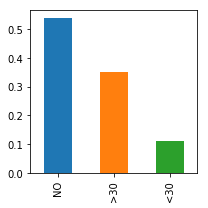

In [9]:
diabetic_df.readmitted.value_counts(normalize=True).plot(kind='bar', figsize=(3,3))

Note: Only 11% of the dataset includes samples with readmitted = '< 30'. An **imbalanced data** issue might be a concern here.

### encounter_id

In [4]:
diabetic_df.encounter_id.nunique()

101766

**This is the unique identifier of the record.**

### patient_nbr

In [11]:
diabetic_df.patient_nbr.nunique()

71518

**That's the unique identifier of the patient**. There are 71,518 patients in the datasets. Each patient might experience 1 or more encounters (addmissions).

For further convenience, I'll now sort the df by patient_nbr and encounter_id:

In [5]:
diabetic_df.sort_values(by=['patient_nbr','encounter_id'], inplace=True)
diabetic_df = diabetic_df.reset_index(drop=True)

In [7]:
# diabetic_df.head()

Exploring the relations between patients and encounters:

In [14]:
encounters_distribution = diabetic_df.groupby('patient_nbr')['encounter_id'].count().sort_values(ascending=False)

In [15]:
encounters_distribution.head()

patient_nbr
88785891    40
43140906    28
88227540    23
1660293     23
23199021    23
Name: encounter_id, dtype: int64

In [16]:
encounters_distribution.tail()

patient_nbr
67638249    1
67636341    1
67633893    1
67633857    1
48164949    1
Name: encounter_id, dtype: int64

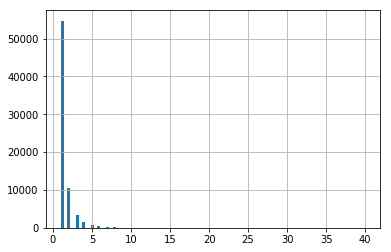

In [17]:
encounters_distribution.hist(bins=100, figsize=(6,4))

The majority of patients (more than 50K out of 71,518) experience exactly 1 encounter. 

### race

In [18]:
diabetic_df.race.value_counts()

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

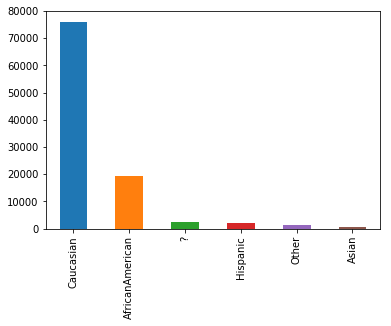

In [19]:
diabetic_df.race.value_counts().plot(kind='bar')

Most of the patients in the dataset are Caucasians. A minority of Hispanic, Asian and Others.

**race values - Issues to consider:**

- There are 2,273 unknown race values in the df (about 2.2%). We don't know yet how many patients are 'involved'. I'll look for the best way to impute these values.
- Putting asside the '?' values, are there any patients, who appear more than once in the df, who have more then one unique value of race? I'll have to address this issue.

In [20]:
# look for patients with more than one value of race
diabetic_df.groupby('patient_nbr')['race'].nunique().sort_values(ascending=False).head()

patient_nbr
51281946     3
107849052    3
106895331    3
1579545      2
12186837     2
Name: race, dtype: int64

In [21]:
# for example
diabetic_df.loc[diabetic_df.patient_nbr == 51281946, ]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
53145,149387580,51281946,Caucasian,Female,[70-80),?,5,6,1,6,...,No,Up,No,No,No,No,No,Ch,Yes,>30
53146,210280446,51281946,?,Female,[70-80),?,1,6,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
53147,223023564,51281946,Hispanic,Female,[70-80),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO


What is the correct race???

In [22]:
# another example
diabetic_df.loc[diabetic_df.patient_nbr == 107849052, ]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
94712,173525454,107849052,Other,Male,[40-50),?,3,1,7,5,...,No,Up,No,No,No,No,No,Ch,Yes,>30
94713,216880200,107849052,Asian,Male,[40-50),?,3,1,1,5,...,No,Down,No,No,No,No,No,Ch,Yes,>30
94714,272400348,107849052,AfricanAmerican,Male,[40-50),?,2,1,7,7,...,No,Down,No,No,No,No,No,Ch,Yes,NO


What is the correct race???

Since, hopefully, the patient's personal data is documented more accurately with each admission, **I'll set the following rule:**<br>In case a patient has more than one value of race - all the values will be set to the most updated value (which is not a '?').<br>
For example:
- patient_nbr 51281946: all values of race will be set to 'Hispanic'
- patient_nbr 107849052: all values of race will be set to 'AfricanAmerican'

In [10]:
(diabetic_df.groupby('patient_nbr')['race'].nunique() > 1).sum()

249

249 patients have more than 1 value of race.

In [14]:
def update_to_most_updated_race(patient):
    """
    update patient's races to the most updated one (which is not '?')
    """
    number_of_updated_records = 0
    patient_ser = diabetic_df.race.loc[diabetic_df.patient_nbr==patient]   # series of patient's races
    most_updated_race = patient_ser.loc[patient_ser.index[-1]]             # the current patient's last race
    i = len(patient_ser)-1                                                 # if current last race is '?',
    while most_updated_race == '?':                                        # loop until race <> '?'
        i -= 1
        most_updated_race = patient_ser.loc[patient_ser.index[i]]
    
    for i in range(0, len(patient_ser)):                   # update all races to the most updated one (where not equal already)
        if patient_ser.loc[patient_ser.index[i]] != most_updated_race:
            diabetic_df.race.loc[patient_ser.index[i]] = most_updated_race
            number_of_updated_records += 1

    return number_of_updated_records

In [15]:
patients_race = (diabetic_df.groupby('patient_nbr')['race'].nunique() > 1)
patients_race = patients_race[patients_race]

number_of_updated_race_records = 0
for patient in patients_race.index:
    number_of_updated_race_records += update_to_most_updated_race(patient)
    
print(f'{number_of_updated_race_records} records were updated')

339 records were updated


In [16]:
(diabetic_df.groupby('patient_nbr')['race'].nunique() > 1).sum()

0

No more patients who have more than 1 value of race. Good.<br>
Now I'll handle patients whose race is '?'

In [27]:
diabetic_df.race.value_counts()

Caucasian          76186
AfricanAmerican    19238
?                   2129
Hispanic            2027
Other               1517
Asian                669
Name: race, dtype: int64

In [28]:
diabetic_df.patient_nbr.loc[diabetic_df.race == '?'].nunique()

1850

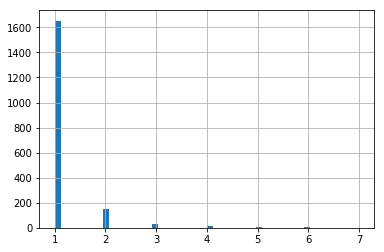

In [29]:
diabetic_df[diabetic_df.race == '?'].groupby('race')['patient_nbr'].value_counts().hist(bins=50)

1,850 patients have '?' as their race(s). Most of them have 1 record of admission.

In [30]:
diabetic_df.race.loc[diabetic_df.race == '?'] = diabetic_df.race.loc[diabetic_df.race == '?'].apply(lambda r: 'Unknown')

In [31]:
diabetic_df.race.value_counts()

Caucasian          76186
AfricanAmerican    19238
Unknown             2129
Hispanic            2027
Other               1517
Asian                669
Name: race, dtype: int64

#### race realtion to target value

In [32]:
race_readmitted_crstb = pd.crosstab(diabetic_df.race, diabetic_df.readmitted)
race_readmitted_crstb

readmitted,<30,>30,NO
race,,,
AfricanAmerican,2156,6661,10421
Asian,72,183,414
Caucasian,8608,27181,40397
Hispanic,210,631,1186
Other,148,451,918
Unknown,163,438,1528


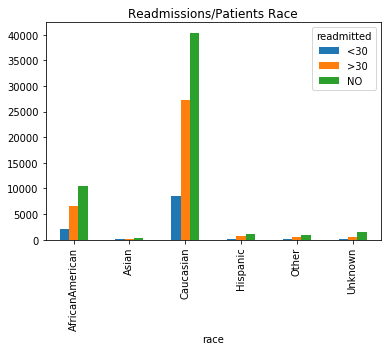

In [33]:
race_readmitted_crstb.plot(kind='bar', title='Readmissions/Patients Race')

In [34]:
# normalize over each row
pd.crosstab(diabetic_df.readmitted, diabetic_df.race, margins=True, normalize='index')

race,AfricanAmerican,Asian,Caucasian,Hispanic,Other,Unknown
readmitted,,,,,,
<30,0.189839,0.006340,0.757947,0.018491,0.013032,0.014352
>30,0.187396,0.005148,0.764693,0.017752,0.012688,0.012322
NO,0.189942,0.007546,0.736312,0.021617,0.016732,0.027851
All,0.189042,0.006574,0.748639,0.019918,0.014907,0.020921


In [35]:
# normalize over each column
pd.crosstab(diabetic_df.readmitted, diabetic_df.race, margins=True, normalize='columns')

race,AfricanAmerican,Asian,Caucasian,Hispanic,Other,Unknown,All
readmitted,,,,,,,
<30,0.112070,0.107623,0.112987,0.103601,0.097561,0.076562,0.111599
>30,0.346242,0.273543,0.356772,0.311297,0.297297,0.205730,0.349282
NO,0.541688,0.618834,0.530242,0.585101,0.605142,0.717708,0.539119


**Insights:**<br>
- The distribution of readmission values are pretty much homogeneous over the races. An exception is the 'Unknown' race, where the share of the 'NO' admission is significantly higher than the '< 30' and '> 30' shares
- Regarding the Asian race: Relatively high 'NO' and low readmissions
- Same with the Unknown race

### gender

In [36]:
diabetic_df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

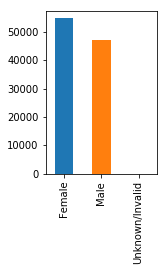

In [37]:
diabetic_df.gender.value_counts().plot(kind='bar', figsize=(2,3))

**gender values - Issues to consider:**

- There are 3 'Unknown/Invalid' gender values in the df. I'll check if it's possible to impute the data, base on other records of these patients. Otherwise I'll drop these records.
- I'll check if there are any patients, who appear more than once in the df, who have more then one unique value of gender.

In [38]:
diabetic_df.loc[diabetic_df.gender == 'Unknown/Invalid']

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
59317,226864668,60524946,Unknown,Unknown/Invalid,[60-70),?,1,1,7,1,...,No,No,No,No,No,No,No,No,No,NO
67850,257364294,78119847,Unknown,Unknown/Invalid,[70-80),?,1,22,7,8,...,No,No,No,No,No,No,No,Ch,Yes,NO
89727,98634858,100695042,Other,Unknown/Invalid,[70-80),?,3,1,1,1,...,No,No,No,No,No,No,No,Ch,Yes,NO


In [39]:
# checking if these 3 patients have other records in the df
diabetic_df.loc[diabetic_df.patient_nbr.isin([60524946,78119847,100695042])]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
59317,226864668,60524946,Unknown,Unknown/Invalid,[60-70),?,1,1,7,1,...,No,No,No,No,No,No,No,No,No,NO
67850,257364294,78119847,Unknown,Unknown/Invalid,[70-80),?,1,22,7,8,...,No,No,No,No,No,No,No,Ch,Yes,NO
89727,98634858,100695042,Other,Unknown/Invalid,[70-80),?,3,1,1,1,...,No,No,No,No,No,No,No,Ch,Yes,NO


The 3 patients who have an 'Unknown/Invalid' gender, do not have other records with valid gender values. Therefore, **I choose to drop these records**.

In [40]:
diabetic_df = diabetic_df[diabetic_df.gender != 'Unknown/Invalid']

In [41]:
diabetic_df.shape

(101763, 50)

In [42]:
# look for patients with more than one value of gender
diabetic_df.groupby('patient_nbr')['gender'].nunique().sort_values(ascending=False).head()

patient_nbr
40867677     2
55500588     2
109210482    2
27607527     1
27610137     1
Name: gender, dtype: int64

**There are 3 patients who have more than 1 unique value of gender.**<br>
I'll follow the rule I set earlier: In case a patient has more than one value of gender - **all the values will be set to the most updated value.**<br>
Note: I could try and analyze these 3 patients' medical diagnoses, in order to find out whether they are males or females, however since only 3 patients are involved, and in addition - their medical parameters might not be clear since they are probably not healthy... I'll pass this analysis.

Since only 3 patients are involved, I'll update their records manually.

In [43]:
diabetic_df.loc[diabetic_df.patient_nbr.isin([40867677,55500588,109210482])]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
42862,220872936,40867677,Unknown,Male,[40-50),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
42863,232356060,40867677,Unknown,Female,[40-50),?,1,5,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,>30
42864,291975978,40867677,Unknown,Male,[40-50),?,3,6,1,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
55175,20729328,55500588,Caucasian,Female,[70-80),?,6,1,1,6,...,No,Steady,No,No,No,No,No,No,Yes,>30
55176,96312942,55500588,Caucasian,Male,[80-90),?,3,1,1,4,...,No,Down,No,No,No,No,No,Ch,Yes,>30
95478,183845022,109210482,Caucasian,Female,[50-60),?,3,1,1,2,...,No,Down,No,No,No,No,No,Ch,Yes,<30
95479,186533256,109210482,Caucasian,Male,[50-60),?,1,6,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,NO


In [44]:
diabetic_df.gender.loc[diabetic_df.encounter_id == 232356060] = 'Male'
diabetic_df.gender.loc[diabetic_df.encounter_id == 20729328] = 'Male'
diabetic_df.gender.loc[diabetic_df.encounter_id == 183845022] = 'Male'

In [45]:
(diabetic_df.groupby('patient_nbr')['gender'].nunique() > 1).sum()

0

#### gender realtion to target value

In [46]:
gender_readmitted_crstb = pd.crosstab(diabetic_df.gender, diabetic_df.readmitted)
gender_readmitted_crstb

readmitted,<30,>30,NO
gender,,,
Female,6151,19516,29038
Male,5206,16029,25823


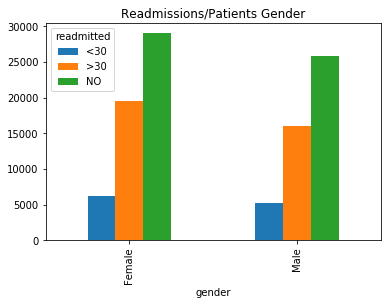

In [47]:
gender_readmitted_crstb.plot(kind='bar', title='Readmissions/Patients Gender')

In [48]:
# normalize over each row
pd.crosstab(diabetic_df.readmitted, diabetic_df.gender, margins=True, normalize='index')

gender,Female,Male
readmitted,,
<30,0.541604,0.458396
>30,0.549050,0.450950
NO,0.529301,0.470699
All,0.537573,0.462427


In [49]:
# normalize over each column
pd.crosstab(diabetic_df.readmitted, diabetic_df.gender, margins=True, normalize='columns')

gender,Female,Male,All
readmitted,,,
<30,0.112439,0.110629,0.111602
>30,0.356750,0.340622,0.349292
NO,0.530811,0.548748,0.539106


**Insight:**<br>
- The distribution of readmission values are pretty much homogeneous over the genders.

### age

In [50]:
diabetic_df.age.value_counts()

[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

No missing or invalid values.

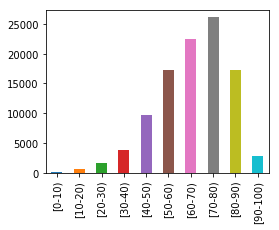

In [51]:
# sorting by age groups
diabetic_df.age.value_counts().sort_index().plot(kind='bar', figsize=(4,3))

**age values - Issue to consider:**<br>
I'll check if there are any patients, who appear more than once in the df, whose age are not chronologically correct.

In [52]:
# look for patients with more than one value of age
(diabetic_df.groupby('patient_nbr')['age'].nunique().sort_values(ascending=False) > 1).sum()

1574

In [53]:
def update_chronological_age(patient):
    """
    update patient's ages in chronological order, where required.
    Here, too (following my rule), the most updated record is the most reliable one.
    """
    number_of_updated_records = 0
    patient_ser = diabetic_df.age.loc[diabetic_df.patient_nbr==patient]   # series of patient's ages
    
    for i in range(len(patient_ser)-1, 1, -1):                                # update ages in chronological order, if needed
        if patient_ser.loc[patient_ser.index[i]] < patient_ser.loc[patient_ser.index[i-1]]:       # wrong chronological order
            diabetic_df.age.loc[patient_ser.index[i-1]] = patient_ser.loc[patient_ser.index[i]]
            patient_ser.loc[patient_ser.index[i-1]] = patient_ser.loc[patient_ser.index[i]]
            number_of_updated_records += 1

    return number_of_updated_records

In [54]:
patients_age = (diabetic_df.groupby('patient_nbr')['age'].nunique() > 1)
patients_age = patients_age[patients_age]

number_of_updated_age_records = 0
for patient in patients_age.index:
    number_of_updated_age_records += update_chronological_age(patient)

print(f'{number_of_updated_age_records} records were updated')

9 records were updated


#### age realtion to target value

In [55]:
age_readmitted_crstb = pd.crosstab(diabetic_df.age, diabetic_df.readmitted)
age_readmitted_crstb

readmitted,<30,>30,NO
age,,,
[0-10),3,26,132
[10-20),40,224,427
[20-30),236,510,911
[30-40),424,1187,2164
[40-50),1027,3279,5380
[50-60),1669,5916,9672
[60-70),2501,7900,12082
[70-80),3069,9472,13524
[80-90),2078,6224,8894


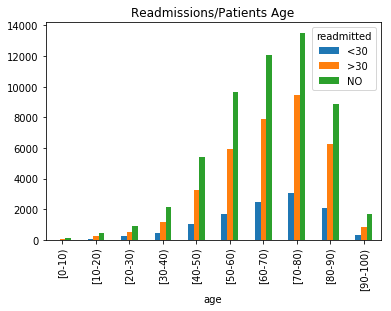

In [56]:
age_readmitted_crstb.plot(kind='bar', title='Readmissions/Patients Age')

In [57]:
# normalize over each row
pd.crosstab(diabetic_df.readmitted, diabetic_df.age, margins=True, normalize='index')

age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
readmitted,,,,,,,,,,
<30,0.000264,0.003522,0.020780,0.037334,0.090429,0.146958,0.220217,0.270230,0.182971,0.027296
>30,0.000731,0.006302,0.014348,0.033394,0.092249,0.166437,0.222253,0.266479,0.175102,0.022704
NO,0.002406,0.007783,0.016606,0.039445,0.098066,0.176300,0.220229,0.246514,0.162119,0.030532
All,0.001582,0.006790,0.016283,0.037096,0.095182,0.169580,0.220935,0.256134,0.168981,0.027436


In [58]:
# normalize over each column
age_readmitted_crstb = pd.crosstab(diabetic_df.readmitted, diabetic_df.age, margins=True, normalize='columns')
age_readmitted_crstb

age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100),All
readmitted,,,,,,,,,,,
<30,0.018634,0.057887,0.142426,0.112318,0.106029,0.096714,0.111240,0.117744,0.120842,0.111032,0.111602
>30,0.161491,0.324168,0.307785,0.314437,0.338530,0.342817,0.351377,0.363399,0.361945,0.289040,0.349292
NO,0.819876,0.617945,0.549789,0.573245,0.555441,0.560468,0.537384,0.518857,0.517213,0.599928,0.539106


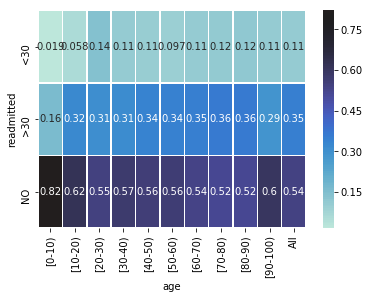

In [59]:
sns.heatmap(age_readmitted_crstb, linewidths=0.5, annot=True, center=0.8)

**Insights:**<br>
- It is noticeable, that the age group [0-10) is different than the rest, as the 'NO' share is very high and the '> 30' share is relatively low
- The [90-100) age group also differs, with a high 'NO' share. The reasons might be different though...

### weight

In [60]:
diabetic_df.weight.value_counts()

?            98566
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

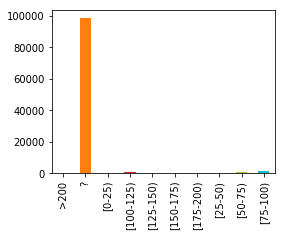

In [61]:
# sorting by weight groups
diabetic_df.weight.value_counts().sort_index().plot(kind='bar', figsize=(4,3))

**weight values - Issues to consider:**

There are 98,566(!) unknown weight values in the df (about 97%). I'll later on drop this feature.

### admission_type_id

In [62]:
diabetic_df.admission_type_id.value_counts()

1    53988
3    18868
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64

No missing values.<br>
It is noticeable that admission_type_id 1 is the most common one. I might later consider to group some of types 4-8.

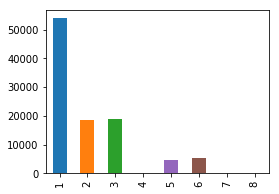

In [63]:
# sorting by admission_type_id
diabetic_df.admission_type_id.value_counts().sort_index().plot(kind='bar', figsize=(4,3))

#### admission_type_id realtion to target value

In [64]:
adtype_readmitted_crstb = pd.crosstab(diabetic_df.admission_type_id, diabetic_df.readmitted)
adtype_readmitted_crstb

readmitted,<30,>30,NO
admission_type_id,,,
1,6221,19309,28458
2,2066,6452,9962
3,1961,5746,11161
4,1,2,7
5,495,1721,2569
6,586,2231,2474
7,0,0,21
8,27,84,209


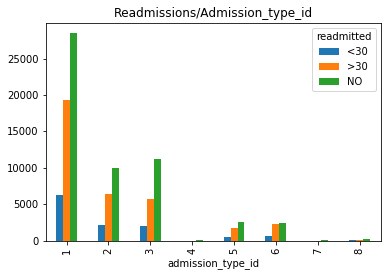

In [65]:
adtype_readmitted_crstb.plot(kind='bar', title='Readmissions/Admission_type_id')

In [66]:
# normalize over each row
pd.crosstab(diabetic_df.readmitted, diabetic_df.admission_type_id, margins=True, normalize='index')

admission_type_id,1,2,3,4,5,6,7,8
readmitted,,,,,,,,
<30,0.547768,0.181914,0.172669,0.000088,0.043585,0.051598,0.000000,0.002377
>30,0.543227,0.181516,0.161654,0.000056,0.048417,0.062766,0.000000,0.002363
NO,0.518729,0.181586,0.203441,0.000128,0.046827,0.045096,0.000383,0.003810
All,0.530527,0.181598,0.185411,0.000098,0.047021,0.051993,0.000206,0.003145


In [67]:
# normalize over each column
adtype_readmitted_crstb = pd.crosstab(diabetic_df.readmitted, diabetic_df.admission_type_id, margins=True, normalize='columns')
adtype_readmitted_crstb

admission_type_id,1,2,3,4,5,6,7,8,All
readmitted,,,,,,,,,
<30,0.115229,0.111797,0.103933,0.1,0.103448,0.110754,0.0,0.084375,0.111602
>30,0.357654,0.349134,0.304537,0.2,0.359666,0.421659,0.0,0.262500,0.349292
NO,0.527117,0.539069,0.591531,0.7,0.536886,0.467586,1.0,0.653125,0.539106


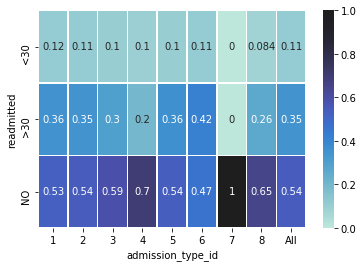

In [68]:
sns.heatmap(adtype_readmitted_crstb, linewidths=0.5, annot=True, center=1)

**Insight:**<br>
- The distribution of readmission values are pretty much homogeneous over the 3 major admission types. However the 5 other, smaller, admission types are less homogeneous.

### discharge_disposition_id

In [69]:
diabetic_df.discharge_disposition_id.value_counts()

1     60232
3     13954
6     12902
18     3691
2      2128
22     1992
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

No missing values.<br>
It is noticeable that discharge_disposition_id 1 is the most common one. I might later consider to group some of the smaller discharge dispositions.

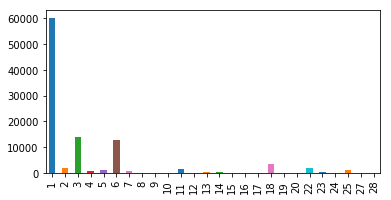

In [70]:
# sorting by discharge_disposition_id
diabetic_df.discharge_disposition_id.value_counts().sort_index().plot(kind='bar', figsize=(6,3))

#### discharge_disposition_id realtion to target value

In [71]:
dis_readmitted_crstb = pd.crosstab(diabetic_df.discharge_disposition_id, diabetic_df.readmitted)
dis_readmitted_crstb

readmitted,<30,>30,NO
discharge_disposition_id,,,
1,5602,21517,33113
2,342,668,1118
3,2046,4916,6992
4,104,278,433
5,247,350,587
6,1638,5362,5902
7,90,221,312
8,15,38,55
9,9,2,10


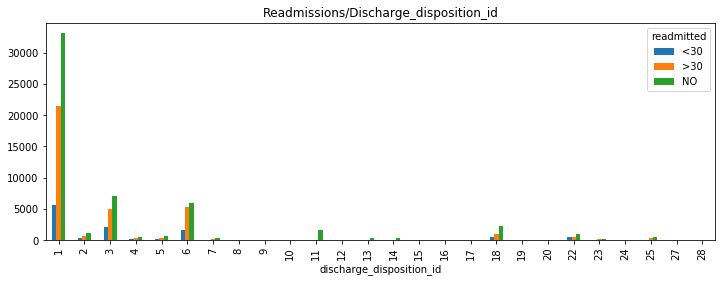

In [72]:
dis_readmitted_crstb.plot(kind='bar', title='Readmissions/Discharge_disposition_id', figsize=(12,4))

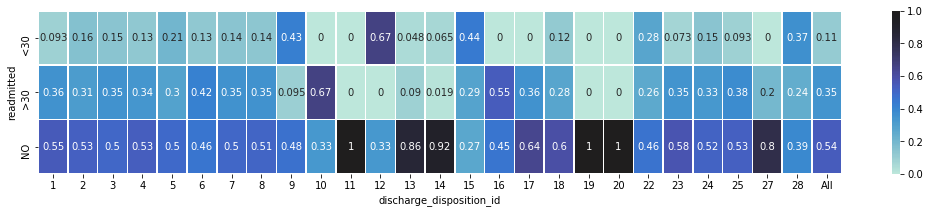

In [73]:
fig, ax = plt.subplots(figsize=(18,3))
dis_readmitted_crstb = \
                   pd.crosstab(diabetic_df.readmitted, diabetic_df.discharge_disposition_id, margins=True, normalize='columns')
sns.heatmap(dis_readmitted_crstb, linewidths=0.5, annot=True, center=1, ax=ax)

**Insight:**<br>
- Some discharge dispositions show interesting data. For example:
    - 11,13,14,19,20,27 - very high 'NO' readmission rate
    - 10,16 - high '> 30' readmission rate
    - 9,12,15,22,28 - high '< 30' readmission rate
- I googled a bit about discharge dispositions, but I couldn't find something to cling to... (I guess the main dispositions probably include 'home without services' and 'home with home health care')

### admission_source_id

In [74]:
diabetic_df.admission_source_id.value_counts()

7     57492
1     29564
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
11        2
14        2
25        2
13        1
Name: admission_source_id, dtype: int64

No missing values.<br>
It is noticeable that admission_source_id 7 and 1 are the most common one. I might later consider to group some of the smaller admission sources.

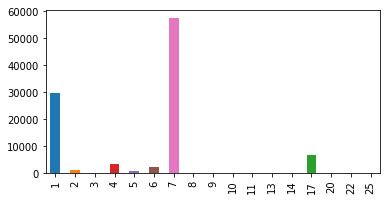

In [75]:
# sorting by admission_source_id
diabetic_df.admission_source_id.value_counts().sort_index().plot(kind='bar', figsize=(6,3))

#### admission_source_id realtion to target value

In [76]:
adsrc_readmitted_crstb = pd.crosstab(diabetic_df.admission_source_id, diabetic_df.readmitted)
adsrc_readmitted_crstb

readmitted,<30,>30,NO
admission_source_id,,,
1,3130,9640,16794
2,111,310,683
3,29,58,100
4,309,672,2206
5,101,236,518
6,212,398,1654
7,6720,21667,29105
8,2,4,10
9,13,16,96


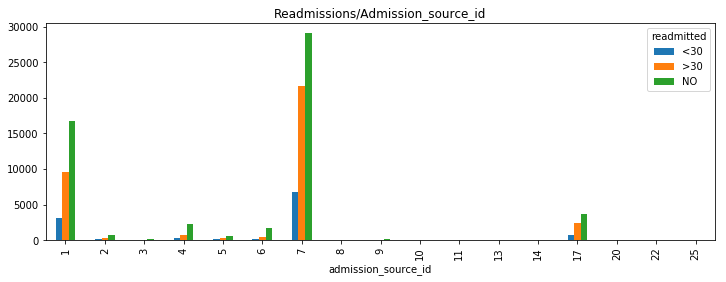

In [77]:
adsrc_readmitted_crstb.plot(kind='bar', title='Readmissions/Admission_source_id', figsize=(12,4))

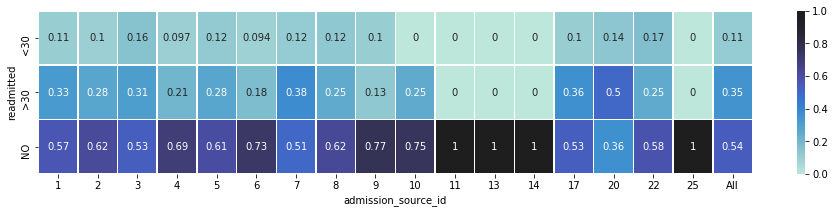

In [78]:
fig, ax = plt.subplots(figsize=(16,3))
adsrc_readmitted_crstb = \
                   pd.crosstab(diabetic_df.readmitted, diabetic_df.admission_source_id, margins=True, normalize='columns')
sns.heatmap(adsrc_readmitted_crstb, linewidths=0.5, annot=True, center=1, ax=ax)

**Insight:**<br>
- The 3 larger admission sources (1,7,17) act similarly, however the 'NO' share is larger in source 1
- I googled a bit about admission sources (in some cases they are also called 'Points of Origin'). I guess the main sources include: Physicial Referral, Clinic Referral, Transfer from a Hospital and more.

### time_in_hospital

In [79]:
diabetic_df.time_in_hospital.value_counts()

3     17756
2     17224
1     14206
4     13924
5      9966
6      7539
7      5859
8      4390
9      3002
10     2342
11     1855
12     1448
13     1210
14     1042
Name: time_in_hospital, dtype: int64

No missing values.<br>
I guess the units are *days* (from 1 day up to 2 weeks of staying in the hospital).

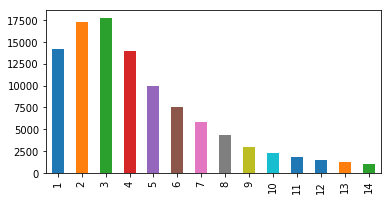

In [80]:
# sorting by time_in_hospital
diabetic_df.time_in_hospital.value_counts().sort_index().plot(kind='bar', figsize=(6,3))

#### time_in_hospital realtion to target value

In [81]:
time_readmitted_crstb = pd.crosstab(diabetic_df.time_in_hospital, diabetic_df.readmitted)
time_readmitted_crstb

readmitted,<30,>30,NO
time_in_hospital,,,
1,1162,4471,8573
2,1712,5919,9593
3,1894,6085,9777
4,1644,5064,7216
5,1199,3586,5181
6,949,2755,3835
7,752,2123,2984
8,625,1589,2176
9,412,1099,1491


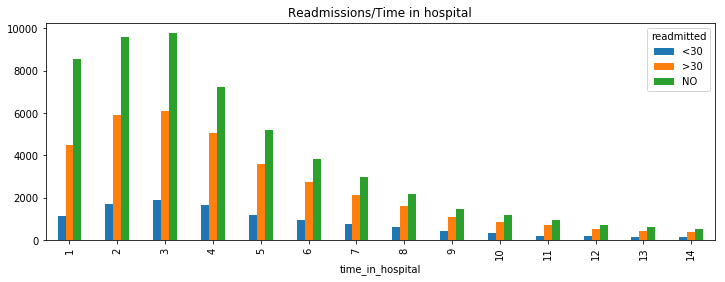

In [82]:
time_readmitted_crstb.plot(kind='bar', title='Readmissions/Time in hospital', figsize=(12,4))

In [83]:
# another point of view
time_readmitted_crstb = pd.crosstab(diabetic_df.readmitted, diabetic_df.time_in_hospital, normalize='columns')
time_readmitted_crstb

time_in_hospital,1,2,3,4,5,6,7,8,9,10,11,12,13,14
readmitted,,,,,,,,,,,,,,
<30,0.081796,0.099396,0.106668,0.118070,0.120309,0.125879,0.128350,0.142369,0.137242,0.143467,0.105121,0.133287,0.123140,0.129559
>30,0.314726,0.343648,0.342701,0.363689,0.359823,0.365433,0.362349,0.361959,0.366089,0.357814,0.376819,0.357735,0.347934,0.362764
NO,0.603477,0.556955,0.550631,0.518242,0.519868,0.508688,0.509302,0.495672,0.496669,0.498719,0.518059,0.508978,0.528926,0.507678


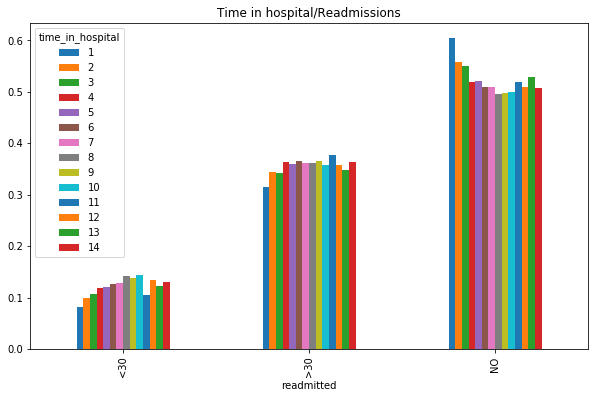

In [84]:
time_readmitted_crstb.plot(kind='bar', title='Time in hospital/Readmissions', figsize=(10,6))

**Insight:**<br>
Among the 'NO' readmissions, it is noticeable that time_in_hospital == 1 "rules". However, does it mean that staying in the hospital for 1 day cure you so you don't have to readmit? or maybe you weren't so sick in the first place?

### payer_code

In [85]:
diabetic_df.payer_code.value_counts()

?     40255
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2531
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64

40,255 unknown values. Can this feature be useful for prediction?

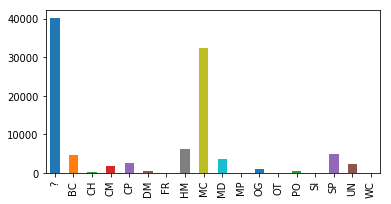

In [86]:
# sorting by payer_code
diabetic_df.payer_code.value_counts().sort_index().plot(kind='bar', figsize=(6,3))

It seems wise enough to drop this feature, as the 'MC' payer code is approx half of all known codes.<br>
However, I'd first like to explore the known payer codes' relations to the target variable.

#### payer_code realtion to target value

In [87]:
payer_readmitted_crstb = pd.crosstab(diabetic_df.payer_code, diabetic_df.readmitted)
payer_readmitted_crstb

readmitted,<30,>30,NO
payer_code,,,
?,4627,13828,21800
BC,426,1301,2928
CH,13,33,100
CM,198,661,1078
CP,214,781,1536
DM,64,220,265
FR,0,0,1
HM,644,2320,3310
MC,3810,11982,16647


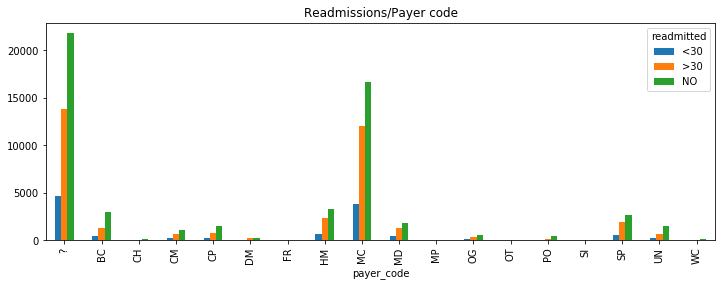

In [88]:
payer_readmitted_crstb.plot(kind='bar', title='Readmissions/Payer code', figsize=(12,4))

In [89]:
# another point of view
payer_readmitted_crstb = pd.crosstab(diabetic_df.readmitted, diabetic_df.payer_code, normalize='columns')
payer_readmitted_crstb

payer_code,?,BC,CH,CM,CP,DM,FR,HM,MC,MD,MP,OG,OT,PO,SI,SP,UN,WC
readmitted,,,,,,,,,,,,,,,,,,
<30,0.114942,0.091515,0.089041,0.102220,0.084552,0.116576,0.0,0.102646,0.117451,0.117780,0.113924,0.131655,0.073684,0.074324,0.127273,0.101857,0.092729,0.037037
>30,0.343510,0.279484,0.226027,0.341249,0.308574,0.400729,0.0,0.369780,0.369370,0.356455,0.493671,0.322362,0.400000,0.243243,0.309091,0.373277,0.284314,0.177778
NO,0.541548,0.629001,0.684932,0.556531,0.606875,0.482696,1.0,0.527574,0.513179,0.525764,0.392405,0.545983,0.526316,0.682432,0.563636,0.524865,0.622958,0.785185


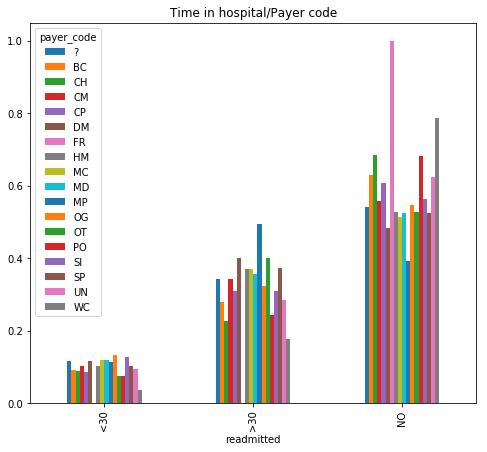

In [90]:
payer_readmitted_crstb.plot(kind='bar', title='Time in hospital/Payer code', figsize=(8,7))

**Insights:**<br>
Although the chart apparently shows interesting findings, most of them are based on few samples (the pink 'FR' appears only once in the dataset).<br>
I'll decide later whether to drop this feature, or maybe use it somehow. For the meanwhile, I'll replace the '?' with the 'Unknown' notation.

In [91]:
diabetic_df.payer_code = diabetic_df.payer_code.replace('?', 'Unknown')

### medical_specialty

In [92]:
diabetic_df.medical_specialty.value_counts()

?                                    49947
InternalMedicine                     14635
Emergency/Trauma                      7565
Family/GeneralPractice                7440
Cardiology                            5351
Surgery-General                       3099
Nephrology                            1613
Orthopedics                           1400
Orthopedics-Reconstructive            1233
Radiologist                           1140
Pulmonology                            871
Psychiatry                             854
Urology                                685
ObstetricsandGynecology                671
Surgery-Cardiovascular/Thoracic        652
Gastroenterology                       564
Surgery-Vascular                       533
Surgery-Neuro                          468
PhysicalMedicineandRehabilitation      391
Oncology                               348
Pediatrics                             254
Hematology/Oncology                    207
Neurology                              203
Pediatrics-

In [93]:
# number of patients that have records with medical_specialty=='?'
len(diabetic_df[diabetic_df['medical_specialty']=='?'].groupby('patient_nbr')['medical_specialty'].nunique())

36023

49,947 unknown values, with 36,023 patients involve (approx half of the dataset). I'll decide later whether to drop this feature or to somehow use it. For the meanwhile, I'll replace the '?' with the 'Unknown' notation.

In [94]:
diabetic_df.medical_specialty = diabetic_df.medical_specialty.replace('?', 'Unknown')

### num_lab_procedures

In [95]:
diabetic_df.num_lab_procedures.value_counts()

1      3208
43     2804
44     2496
45     2376
38     2212
40     2201
46     2189
41     2117
42     2113
47     2106
39     2101
37     2079
49     2066
48     2058
36     1962
51     1925
50     1924
35     1907
54     1888
56     1839
52     1838
55     1836
53     1802
57     1747
58     1708
34     1677
61     1638
59     1623
60     1610
63     1450
       ... 
89       73
90       65
91       61
93       56
92       48
95       46
94       45
97       31
96       28
98       26
101      13
100      13
99        9
102       8
103       6
105       6
106       5
109       4
108       4
111       3
113       3
104       3
114       2
126       1
132       1
107       1
118       1
129       1
120       1
121       1
Name: num_lab_procedures, Length: 118, dtype: int64

### num_procedures

In [96]:
diabetic_df.num_procedures.value_counts()

0    46652
1    20741
2    12716
3     9443
6     4954
4     4180
5     3077
Name: num_procedures, dtype: int64

### num_medications

In [97]:
diabetic_df.num_medications.value_counts()

13    6086
12    6004
11    5795
15    5792
14    5707
16    5430
10    5346
17    4919
9     4913
18    4523
8     4353
19    4078
20    3691
7     3484
21    3229
22    2867
6     2698
23    2426
24    2109
5     2017
25    1888
26    1608
27    1432
4     1417
28    1233
29    1000
3      900
30     849
31     712
32     623
      ... 
45      88
47      74
49      61
48      60
50      55
52      54
51      43
53      40
56      37
54      33
55      32
57      26
58      25
60      23
59      20
62      15
63      14
61      14
65      12
64       8
68       7
67       7
69       5
66       5
72       3
70       2
75       2
74       1
79       1
81       1
Name: num_medications, Length: 75, dtype: int64

### number_outpatient and number_inpatient

In [98]:
diabetic_df.number_outpatient.value_counts()

0     85024
1      8547
2      3594
3      2042
4      1099
5       533
6       303
7       155
8        98
9        83
10       57
11       42
13       31
12       30
14       28
15       20
16       15
17        8
21        7
20        7
22        5
18        5
19        3
24        3
27        3
23        2
25        2
26        2
29        2
33        2
35        2
36        2
40        1
28        1
34        1
37        1
38        1
39        1
42        1
Name: number_outpatient, dtype: int64

In [99]:
diabetic_df.number_inpatient.value_counts()

0     67627
1     19521
2      7566
3      3411
4      1622
5       812
6       480
7       268
8       151
9       111
10       61
11       49
12       34
13       20
14       10
15        9
16        6
19        2
17        1
18        1
21        1
Name: number_inpatient, dtype: int64

In [100]:
# encounters in which both number_outpatient and number_inpatient == 0
len(diabetic_df.loc[(diabetic_df['number_outpatient']==0) & (diabetic_df['number_inpatient']==0), 
                    'encounter_id':'number_inpatient'])

59082

While understanding the meaning of *Outpatient* and *Inpatient*, I find it strange that there are 59,082 encounters where both *number_outpatient* and *number_inpatient* are 0. I'll explore that a bit more:

In [101]:
# looking at some samples
diabetic_df.loc[(diabetic_df['number_outpatient']>2) | (diabetic_df['number_inpatient']>2), 
               ['encounter_id','patient_nbr','number_outpatient','number_inpatient']].head(20)

,encounter_id,patient_nbr,number_outpatient,number_inpatient
15,171414378,1629,3,2
48,36676056,11511,0,3
60,19423404,13041,1,3
61,27586146,13041,1,4
62,37761462,13041,0,4
128,61259154,30735,1,3
129,63586176,30735,1,4
130,67267530,30735,1,5
131,72153630,30735,1,5
132,73126506,30735,1,6


By looking at the data, I can realize that *number_outpatient* is supposed to indicate the number of outpatient encounters of the patient **preceding the current encounter**. And similarly with *number_inpatient*. <br>
However, it seems that there are a lot of wrong values in the dataset, e.g. patient 13041 (from 1,4 to 0,4) or patient 30735 (from 1,6 to 0,5). <br>
Unfortunately, there's no way I can fix the wrong values, as I cannot guess whether a patient in a certain encounter is 'outpatient' or 'inpatient'.

### number_emergency

In [102]:
diabetic_df.number_emergency.value_counts()

0     90380
1      7677
2      2042
3       725
4       374
5       192
6        94
7        73
8        50
10       34
9        33
11       23
13       12
12       10
22        6
18        5
16        5
19        4
20        4
14        3
15        3
21        2
25        2
76        1
54        1
24        1
28        1
29        1
37        1
42        1
46        1
64        1
63        1
Name: number_emergency, dtype: int64

In [103]:
# number of patients who don't have any 'emergency' records
len(diabetic_df[diabetic_df['number_emergency']==0].groupby('patient_nbr')['number_emergency'].nunique())

66865

About 89% of all encounters (90,380 out of 101,763), and 93% of all patients (66,865 out of 71,515) do not have an 'emergency' record. I'll later consider dropping this feature.

### diag_1, _2 and _3

In [104]:
diabetic_df.diag_1.value_counts().head()

428    6862
414    6580
786    4016
410    3614
486    3508
Name: diag_1, dtype: int64

In [105]:
diabetic_df[diabetic_df['diag_1']=='?'].diag_1.value_counts()

?    21
Name: diag_1, dtype: int64

In [106]:
diabetic_df.diag_1 = diabetic_df.diag_1.replace('?', 'Unknown')

In [107]:
diabetic_df.diag_2.value_counts().head()

276    6752
428    6662
250    6071
427    5036
401    3736
Name: diag_2, dtype: int64

In [108]:
diabetic_df[diabetic_df['diag_2']=='?'].diag_2.value_counts()

?    358
Name: diag_2, dtype: int64

In [109]:
diabetic_df.diag_2 = diabetic_df.diag_2.replace('?', 'Unknown')

In [110]:
diabetic_df.diag_3.value_counts().head()

250    11555
401     8288
276     5175
428     4577
427     3955
Name: diag_3, dtype: int64

In [111]:
diabetic_df[diabetic_df['diag_3']=='?'].diag_3.value_counts()

?    1423
Name: diag_3, dtype: int64

In [112]:
diabetic_df.diag_3 = diabetic_df.diag_3.replace('?', 'Unknown')

Nominal values of 3 diagnoses.<br>
I'll handle these features later on.

### number_diagnoses

In [113]:
diabetic_df.number_diagnoses.value_counts()

9     49473
5     11392
8     10616
7     10393
6     10161
4      5536
3      2835
2      1023
1       219
16       45
10       17
13       16
11       11
15       10
12        9
14        7
Name: number_diagnoses, dtype: int64

### max_glu_serum : metformin-pioglitazone

In [114]:
diabetic_df.max_glu_serum.value_counts()

None    96417
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

About 95% *None* values. I guess *None* means the test was not taken.

In [115]:
diabetic_df.A1Cresult.value_counts()

None    84745
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

About 83% *None* values. I guess *None* means the test was not taken.

In [116]:
diabetic_df.metformin.value_counts()

No        81776
Steady    18345
Up         1067
Down        575
Name: metformin, dtype: int64

A medication for the treatment of type 2 diabetes.<br>
About 80% *No* values. I guess *No* means the medicine was not prescribed to the patient during an encounter. *Up, Down* and *Steady* probably indicate the change in dosage during the encounter.

In [117]:
diabetic_df.repaglinide.value_counts()

No        100224
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64

An antidiabetic drug.<br>
About 98% *No* values.

In [118]:
diabetic_df.nateglinide.value_counts()

No        101060
Steady       668
Up            24
Down          11
Name: nateglinide, dtype: int64

A drug for the treatment of type 2 diabetes.<br>
About 99% *No* values.

**Another 20 drugs share the same values (*No, Steady, Up, Down*)**

In [119]:
# print(diabetic_df.chlorpropamide.value_counts())
# print(diabetic_df.glimepiride.value_counts())
# print(diabetic_df.acetohexamide.value_counts())
# print(diabetic_df.glipizide.value_counts())
# print(diabetic_df.glyburide.value_counts())
# print(diabetic_df.tolbutamide.value_counts())
# print(diabetic_df.pioglitazone.value_counts())
# print(diabetic_df.rosiglitazone.value_counts())
# print(diabetic_df.acarbose.value_counts())
# print(diabetic_df.miglitol.value_counts())
# print(diabetic_df.troglitazone.value_counts())
# print(diabetic_df.tolazamide.value_counts())
# print(diabetic_df.examide.value_counts())
# print(diabetic_df.citoglipton.value_counts())
# print(diabetic_df.insulin.value_counts())
# print(diabetic_df.glyburide-metformin.value_counts())
# print(diabetic_df.glipizide-metformin.value_counts())
# print(diabetic_df.glimepiride-pioglitazone.value_counts())
# print(diabetic_df.metformin-rosiglitazone.value_counts())
# print(diabetic_df.metformin-pioglitazone.value_counts())

Standardization-sake, I'll rename some features' names, replacing '-' with '_'

In [120]:
diabetic_df.rename(columns={'glyburide-metformin':'glyburide_metformin',
                            'glipizide-metformin':'glipizide_metformin',
                            'glimepiride-pioglitazone':'glimepiride_pioglitazone',
                            'metformin-rosiglitazone':'metformin_rosiglitazone',
                            'metformin-pioglitazone':'metformin_pioglitazone'
                           }, inplace=True)

### change

In [121]:
diabetic_df.change.value_counts()

No    54754
Ch    47009
Name: change, dtype: int64

I guess this feature indicates whether there was a change in dosage/type of medications.

### diabetesMed

In [122]:
diabetic_df.diabetesMed.value_counts()

Yes    78361
No     23402
Name: diabetesMed, dtype: int64

I guess this feature indicates whether a diabetic medication was prescribed.

### Another look at the target variable: readmitted

I'd like to check if there are any records (encounters) with *readmitted* == 'NO' where a later encounter of the patient exists. <br>Those labels might be a mistake and the encounters should probably be removed.<br>
Note: Patients that are recorded as readmitted == "< 30" or "> 30" however no following "readmission" records exist in the dataset, will not be considered as invalid data. Rather I assume the following encounter is just not included in the dataset.

In [123]:
# find all patients that fulfill ALL of the following conditions:
#    - have more than one encounter
#    - at least in one encounter, readmitted==NO
#    - there's readmitted==NO in any encounter other than the last one

df = diabetic_df.groupby('patient_nbr').filter(lambda p: 
                                               (len(p) > 1) &
                                               ((p.readmitted == 'NO').any()) & 
                                               ((p.readmitted.iloc[len(p)-1] != 'NO') | (len(p[p.readmitted == 'NO']) > 1))
                                               )

In [124]:
# number of encounters in df (including those that are OK)
df.shape

(1538, 50)

In [125]:
# number of patients with problematic readmitted values
df.patient_nbr.nunique()

489

In [126]:
# Within the df, the following encounters are OK:
#    - encounters with readmitted <> 'NO'
#    - last encounter of each patient 
# To locate the problematic encounters, I'll filter out the OK ones.
                                                                               
last_encounters = df.groupby('patient_nbr')['encounter_id'].max()               # first, find the last encounter of each patient
df_problematic_encounters = df.loc[~df['encounter_id'].isin(last_encounters)]   # and filter them out
                                            # then, filter out all the '<30','>30' encounters, leaving only the problematic ones
df_problematic_encounters = df_problematic_encounters[df_problematic_encounters.readmitted == 'NO'] 

In [127]:
df_problematic_encounters.shape

(490, 50)

There are 490 encounters with wrong readmitted value. <br>Since there's no way I can know with which valid value they should be replaced, **I'll just drop these encounters**.

In [128]:
diabetic_df = diabetic_df[~diabetic_df.encounter_id.isin(df_problematic_encounters.encounter_id)]

In [129]:
diabetic_df.shape

(101273, 50)

## 3. Feature Engineering

In [130]:
X_all = diabetic_df.drop(columns=['encounter_id','patient_nbr','readmitted'])

In [131]:
y = diabetic_df.readmitted

### Dropping features with "low variance"
In order to reduce dimensions, I will now *manually* drop columns which have a 'dominant' value. If a value's portion in a certain column is greater than a threshold that I'll set, this column will probably won't contribute towards explaining the target variable, and therefore will be dropped from the df.

In [132]:
dominant_value_threshold = 0.85                      # the "variance" threshold
max_colname_len = len(max(X_all.columns, key=len))   # for formatting the printout

for col in X_all:
    normalize_value_counts = X_all[col].value_counts(normalize=True, sort=True, ascending=False)  # percentages of value_counts
    dominant_value = list(normalize_value_counts.keys())[0]
    portion_of_dominant_value = list(normalize_value_counts)[0]
    if portion_of_dominant_value >= dominant_value_threshold:
        print(f'Dropping {col:{max_colname_len}}. Portion of "{dominant_value}" was {portion_of_dominant_value:.5f}')
        X_all.drop(columns=col, inplace=True)

Dropping weight                  . Portion of "?" was 0.96844
Dropping number_emergency        . Portion of "0" was 0.88867
Dropping max_glu_serum           . Portion of "None" was 0.94723
Dropping repaglinide             . Portion of "No" was 0.98491
Dropping nateglinide             . Portion of "No" was 0.99312
Dropping chlorpropamide          . Portion of "No" was 0.99915
Dropping glimepiride             . Portion of "No" was 0.94904
Dropping acetohexamide           . Portion of "No" was 0.99999
Dropping glipizide               . Portion of "No" was 0.87536
Dropping glyburide               . Portion of "No" was 0.89522
Dropping tolbutamide             . Portion of "No" was 0.99977
Dropping pioglitazone            . Portion of "No" was 0.92804
Dropping rosiglitazone           . Portion of "No" was 0.93727
Dropping acarbose                . Portion of "No" was 0.99696
Dropping miglitol                . Portion of "No" was 0.99962
Dropping troglitazone            . Portion of "No" was 

In [133]:
X_all.shape

(101273, 23)

### Categorical (Nominal/Ordinal) and Numerical (Discrete/Continuous) Features

#### *Nominal Features*

In some features (numeric and non-numeric) there is **no concept of ordering** amongst the categories of that feature.<br>
Some of the them have a lot of categories. Trying to (label)encode them to binary features will create a very "wide" dataset. Therefore I will "group" them into a smaller number of categories.

In [134]:
X_all.nunique().sort_values(ascending=False)

diag_3                      789
diag_2                      749
diag_1                      717
num_lab_procedures          118
num_medications              75
medical_specialty            73
number_outpatient            39
discharge_disposition_id     26
number_inpatient             21
payer_code                   18
admission_source_id          17
number_diagnoses             16
time_in_hospital             14
age                          10
admission_type_id             8
num_procedures                7
race                          6
A1Cresult                     4
metformin                     4
insulin                       4
change                        2
gender                        2
diabetesMed                   2
dtype: int64

From the above, I'll now handle the following features:<br>
diag_1, diag_2, diag_3, medical_specialty, discharge_disposition_id, payer_code, and admission_source_id.

**diag_1, diag_2, diag_3**

While trying to figure-out how to reduce these features' "size", I looked for some information regarding codes of diabetic diagnosis.<br>I found **the diagnoses codes** on http://www.icd9data.com:

    001-139  Infectious And Parasitic Diseases
    140-239  Neoplasms
    240-279  Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders
    280-289  Diseases Of The Blood And Blood-Forming Organs
    290-319  Mental Disorders
    320-389  Diseases Of The Nervous System And Sense Organs
    390-459  Diseases Of The Circulatory System
    460-519  Diseases Of The Respiratory System
    520-579  Diseases Of The Digestive System
    580-629  Diseases Of The Genitourinary System
    630-679  Complications Of Pregnancy, Childbirth, And The Puerperium
    680-709  Diseases Of The Skin And Subcutaneous Tissue
    710-739  Diseases Of The Musculoskeletal System And Connective Tissue
    740-759  Congenital Anomalies
    760-779  Certain Conditions Originating In The Perinatal Period
    780-799  Symptoms, Signs, And Ill-Defined Conditions
    800-999  Injury And Poisoning
    V01-V91  Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services
    E000-E999  Supplementary Classification Of External Causes Of Injury And Poisoning
    
So, all I have to do now, is "map" the hundreds of given categories into the above 19 "bins" (actually 20, including "Unknown" values).

In [135]:
def map_diag(diag):
    '''
    Find the appropriate "bin" for each given diagnosis code value
    '''
    codes_dict = {'001': (  1, 139), '140': (140, 239), '240': (240, 279), '280': (280, 289), '290': (290, 319),
                  '320': (320, 389), '390': (390, 459), '460': (460, 519), '520': (520, 579), '580': (580, 629),
                  '630': (630, 679), '680': (680, 709), '710': (710, 739), '740': (740, 759), '760': (760, 779),
                  '780': (780, 799), '800': (800, 999), 'E00': ('E000','E999'),'V01': ('V01','V91'), 'Unknown':('Unknown')
                  }
    bin = 'Unknown'
    try:
        diag_num = float(diag)
        for k in codes_dict:
            if codes_dict[k][0] <= diag_num <= codes_dict[k][1]:
                bin = k
                continue
    except:
        if diag[0] == 'E':
            bin = 'E00'
        elif diag[0] == 'V':
            bin = 'V01'          
    return bin

In [136]:
X_all['diag_1_groups'] = X_all['diag_1'].apply(map_diag)
X_all['diag_2_groups'] = X_all['diag_2'].apply(map_diag)
X_all['diag_3_groups'] = X_all['diag_3'].apply(map_diag)

In [137]:
# X_all['diag_1_groups'].value_counts()
# X_all['diag_2_groups'].value_counts()
# X_all['diag_3_groups'].value_counts()

In [138]:
X_all.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)

**medical_specialty**

In order to reduce the number of categories, I'll join some of them (according to their names):

In [139]:
# X_all.medical_specialty.sort_values().unique()

In [140]:
medical_specialty_map = {'AllergyandImmunology': 0,
                         'Anesthesiology': 1,
                         'Anesthesiology-Pediatric': 2,
                         'Cardiology': 3, 'Cardiology-Pediatric': 3,
                         'DCPTEAM': 4, 
                         'Dentistry': 5,
                         'Dermatology': 6,
                         'Emergency/Trauma': 7,
                         'Endocrinology': 8, 'Endocrinology-Metabolism': 8,
                         'Family/GeneralPractice': 9,
                         'Gastroenterology': 10,
                         'Gynecology': 11,
                         'Hematology': 12, 'Hematology/Oncology': 12, 
                         'Hospitalist': 13,
                         'InfectiousDiseases': 14, 
                         'InternalMedicine': 15, 
                         'Nephrology': 16,
                         'Neurology': 17, 
                         'Neurophysiology': 18,
                         'Obsterics&Gynecology-GynecologicOnco': 19, 'Obstetrics': 19, 'ObstetricsandGynecology': 19, 
                         'Oncology': 20, 
                         'Ophthalmology': 21,
                         'Orthopedics': 22, 'Orthopedics-Reconstructive': 22, 
                         'Osteopath': 23,
                         'Otolaryngology': 24, 
                         'OutreachServices': 25, 
                         'Pathology': 26, 
                         'Pediatrics': 27, 'Pediatrics-AllergyandImmunology': 27, 
                         'Pediatrics-CriticalCare':27, 'Pediatrics-EmergencyMedicine': 27, 
                         'Pediatrics-Endocrinology': 27, 'Pediatrics-Hematology-Oncology': 27, 
                         'Pediatrics-InfectiousDiseases': 27, 'Pediatrics-Neurology': 27, 'Pediatrics-Pulmonology': 27, 
                         'Perinatology': 28,
                         'PhysicalMedicineandRehabilitation': 29, 
                         'PhysicianNotFound': 30,
                         'Podiatry': 31, 
                         'Proctology': 32, 
                         'Psychiatry': 33, 'Psychiatry-Addictive': 33, 'Psychiatry-Child/Adolescent': 33, 
                         'Psychology': 34, 
                         'Pulmonology': 35,
                         'Radiologist': 36, 'Radiology': 36, 
                         'Resident': 37, 
                         'Rheumatology': 38, 
                         'Speech': 39,
                         'SportsMedicine': 40, 
                         'Surgeon': 41, 'Surgery-Cardiovascular': 41, 'Surgery-Cardiovascular/Thoracic': 41, 
                         'Surgery-Colon&Rectal': 41, 'Surgery-General': 41, 'Surgery-Maxillofacial': 41, 
                         'Surgery-Neuro': 41, 'Surgery-Pediatric': 41, 'Surgery-Plastic': 41, 
                         'Surgery-PlasticwithinHeadandNeck': 41, 'Surgery-Thoracic': 41, 'Surgery-Vascular': 41, 
                         'SurgicalSpecialty': 41, 
                         'Urology':42,
                         'Unknown': 'Unknown'}

X_all['medical_specialty_groups'] = X_all['medical_specialty'].map(medical_specialty_map)

In [141]:
# X_all['medical_specialty_groups'].value_counts()

In [142]:
X_all.drop(columns=['medical_specialty'], inplace=True)

#### *Ordinal Features*

In the *age* feature, **order has a meaning** amongst its values. Therefore I'll convert it to numerical data that is ordered.

In [143]:
age_map = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
           '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}

X_all['age'] = X_all['age'].map(age_map)

### Looking for correlation among the features

#### *Numeric (continuous) Features*

In [144]:
X_numeric = X_all.drop(columns=['admission_type_id','discharge_disposition_id','admission_source_id']).\
                       select_dtypes(include='number')
X_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101273 entries, 0 to 101765
Data columns (total 8 columns):
age                   101273 non-null int64
time_in_hospital      101273 non-null int64
num_lab_procedures    101273 non-null int64
num_procedures        101273 non-null int64
num_medications       101273 non-null int64
number_outpatient     101273 non-null int64
number_inpatient      101273 non-null int64
number_diagnoses      101273 non-null int64
dtypes: int64(8)
memory usage: 7.0 MB


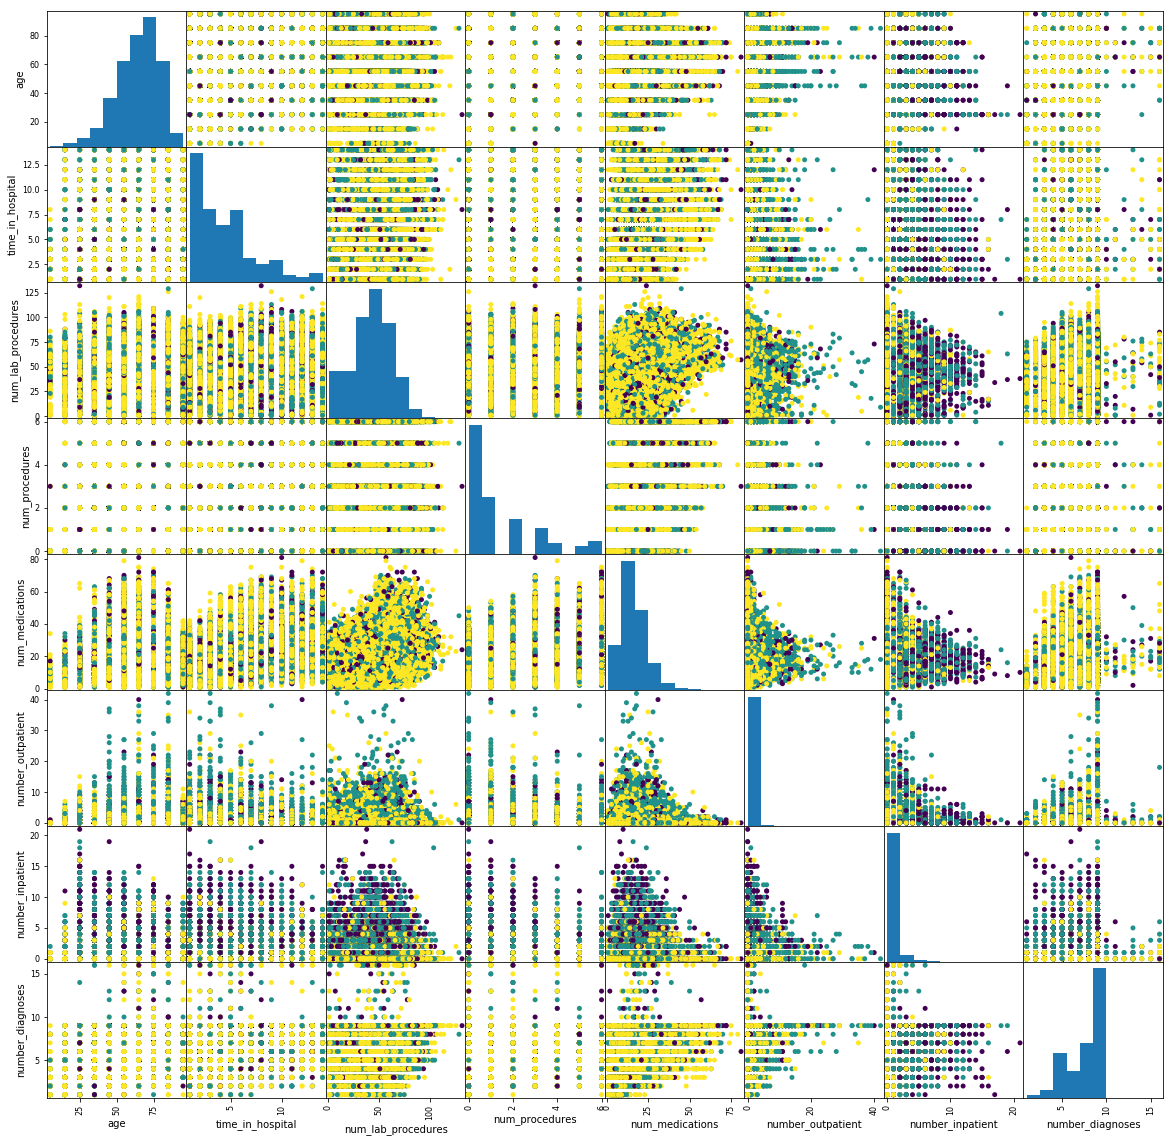

In [145]:
df_4scatter = pd.concat([X_numeric, y], axis=1)
target_map = {'<30': 0, '>30': 1, 'NO': 2}
df_4scatter['readmitted'] = df_4scatter['readmitted'].map(target_map)

scatter = scatter_matrix(df_4scatter.ix[:, :8], figsize=(20, 20), c=df_4scatter['readmitted'], alpha=1, s=100)

Difficult to distinguish between the colors (the target classes). <br>
Difficult to see correlations between the features.<br>
I'll try it in a different way:

In [146]:
corr_matrix = X_numeric.corr()

In [147]:
corr_matrix

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,number_diagnoses
age,1.000000,0.107872,0.020637,-0.029973,0.041799,0.023654,-0.044318,0.242553
time_in_hospital,0.107872,1.000000,0.318121,0.191825,0.466337,-0.008824,0.074577,0.220697
num_lab_procedures,0.020637,0.318121,1.000000,0.058093,0.267767,-0.006984,0.040240,0.153431
num_procedures,-0.029973,0.191825,0.058093,1.000000,0.386286,-0.024878,-0.065779,0.074495
num_medications,0.041799,0.466337,0.267767,0.386286,1.000000,0.045061,0.064207,0.261917
number_outpatient,0.023654,-0.008824,-0.006984,-0.024878,0.045061,1.000000,0.106958,0.094283
number_inpatient,-0.044318,0.074577,0.040240,-0.065779,0.064207,0.106958,1.000000,0.102892
number_diagnoses,0.242553,0.220697,0.153431,0.074495,0.261917,0.094283,0.102892,1.000000


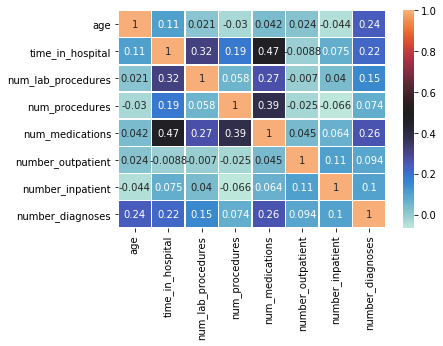

In [148]:
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, linewidths=0.5, annot=True, center=0.5)

It is noticeable, that *time_in_hospital* is a significant feature. Its correlation to num_medications is (not surprisingly) the highest (0.47) and its corellation to *num_lab_procedures* is also relatively high (0.32).<br>
Another noticeable correlation is *num_medications* with *num_procedures* (0.39).<br>
As of now, I will not create any "interaction features".

### Converting features into dummy variables

In [149]:
# X_all.info()

In [150]:
X_all_dummies = pd.get_dummies(X_all, columns=['race','gender','admission_type_id','discharge_disposition_id',
                                               'admission_source_id','payer_code','A1Cresult','metformin','insulin',
                                               'change','diabetesMed','diag_1_groups','diag_2_groups','diag_3_groups',
                                               'medical_specialty_groups'])

In [151]:
# X_all_dummies.info()

Dropping dummy features which represent 'Unknown' values:

In [152]:
X_all_dummies.drop(columns=[col for col in X_all_dummies.columns if col[-7:] == 'Unknown'], inplace=True)

In [153]:
# X_all_dummies.info()

### Feature Selection

I'll present two methods:
- SelectKBest
- Feature Importance

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_all_dummies, y, test_size=0.3, random_state=4014)
X_train.shape, X_test.shape

((70891, 196), (30382, 196))

In [155]:
k=30

#### SelectKBest

In [156]:
selector = SelectKBest(chi2, k=k)
selector.fit(X_train, y_train)
# selector.scores_

SelectKBest(k=30, score_func=<function chi2 at 0x000001DF39D1D488>)

In [157]:
# index of the features selected
cols = selector.get_support(indices=True) 
# cols

In [158]:
# Create new dataframe with only desired columns
X_KBest = X_train.iloc[:, cols]
# X_KBest.info()

#### Selecting by Random Forest feature importance

In [159]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

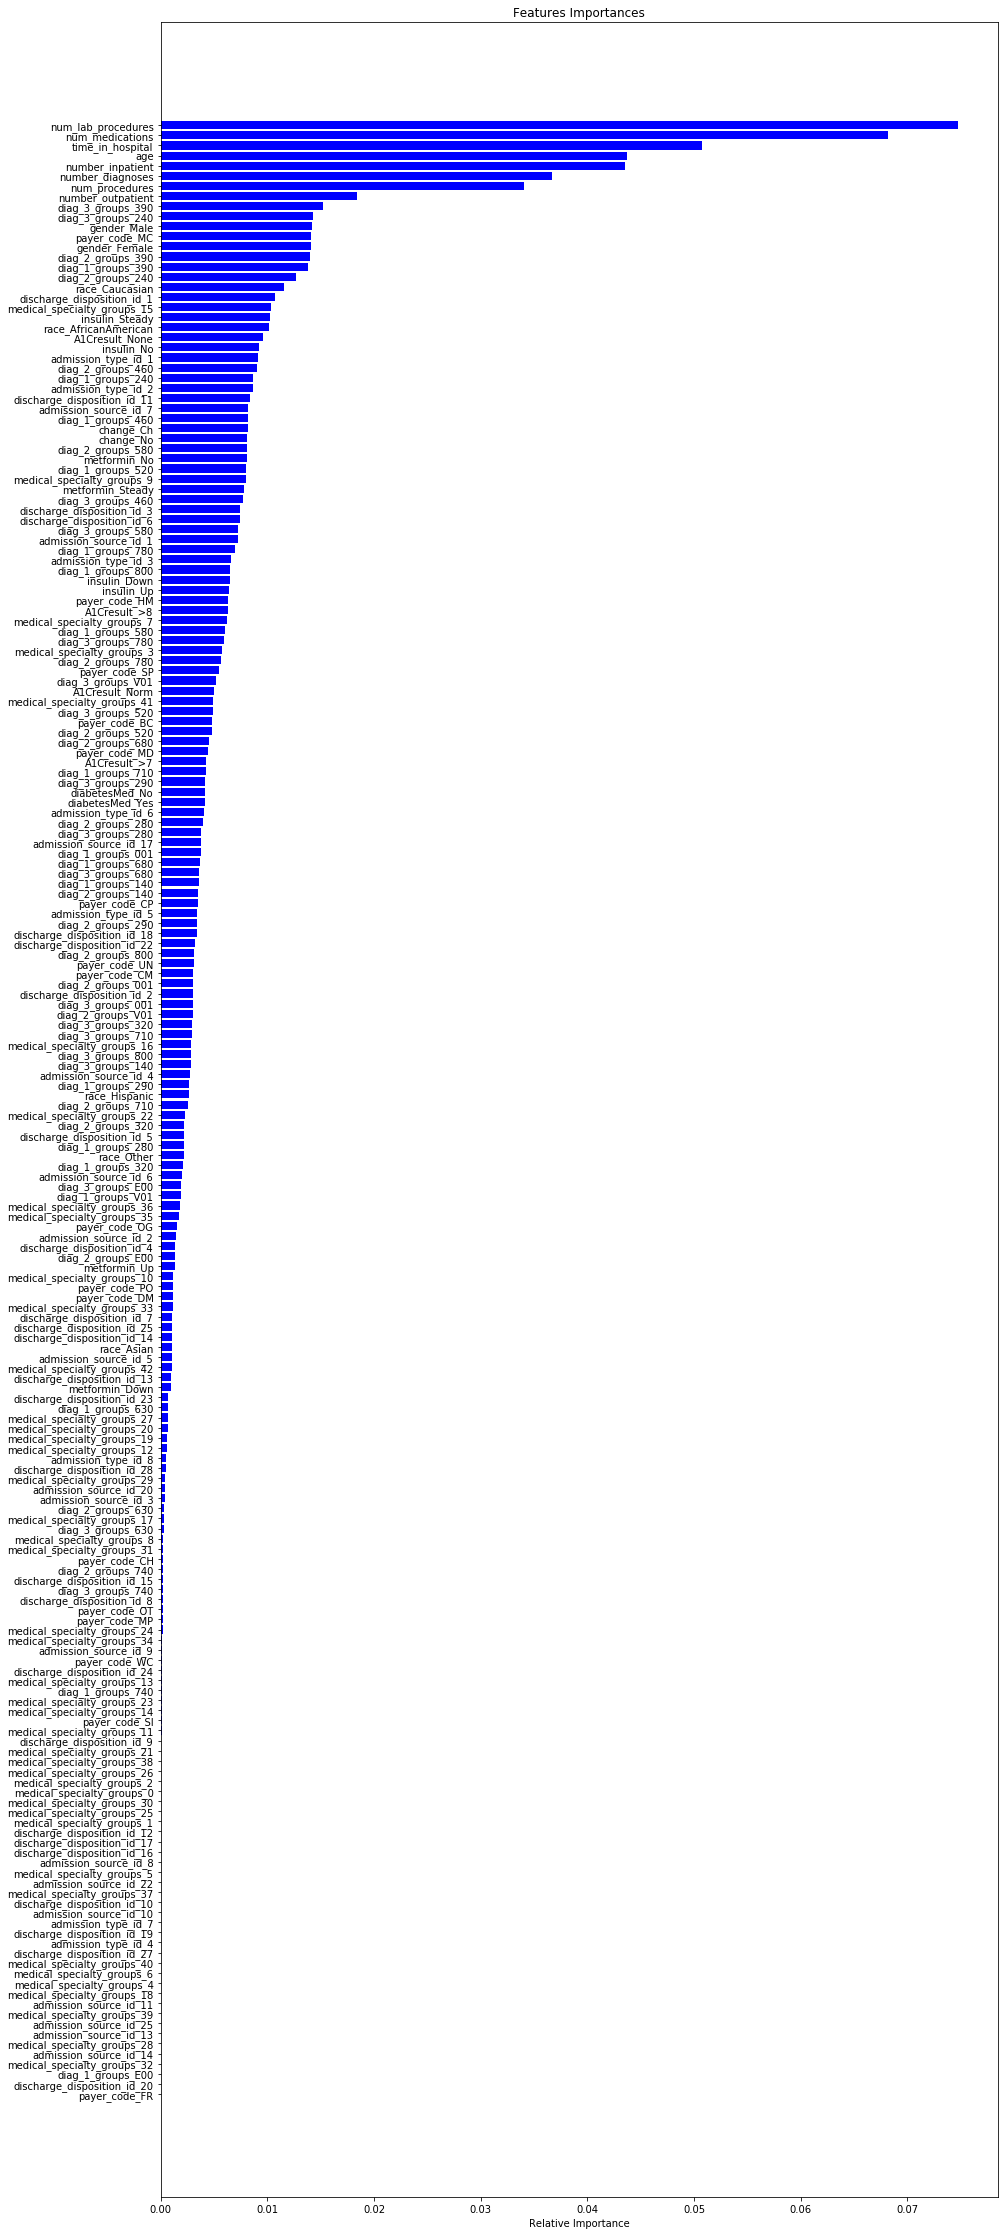

In [160]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,40))
plt.title('Features Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [161]:
k_important_features = ([features[i] for i in indices])[-k:]

What features should I select?

In [162]:
common_best_features = set(X_KBest) & set(k_important_features)
print(len(common_best_features))
common_best_features

12


{'admission_source_id_7',
 'age',
 'discharge_disposition_id_1',
 'discharge_disposition_id_11',
 'insulin_No',
 'num_lab_procedures',
 'num_medications',
 'num_procedures',
 'number_diagnoses',
 'number_inpatient',
 'number_outpatient',
 'time_in_hospital'}

In [163]:
len(set(X_KBest) | set(k_important_features))

48

It's interesting looking at the most contributing features, "agreed by" both SelectKBest and feature_importances: The patient's age, the time s/he spent in the hospital, the amount of procedures/lab procedures/medications/diagnoses that s/he experienced while being under supervision, the number of time s/he previously admitted as an out/inpatient, one of the drugs s/he got (insulin ofcourse), one of the admission sources and one of the discharge dispositions.<br>
However, To be "on the safe side", I'll select the "union" set of features (49 most contributing features).

In [164]:
selected_features = set(X_KBest) | set(k_important_features)

In [165]:
X_train_selected = X_train.loc[:, selected_features]

In [166]:
# X_train_selected.info()

### Scaling

Looking at the dataset, we have dummy features and features with values between 0 and 132. Apparently, there's no significant advantage in using a scaler. <br>

*Note:* Since I'm using PCA, which is sensitive to data scaling, I tried using both StandardScaler and MinMaxScaler, but the models' scores were worse.

In [167]:
X_train_selected.max()

discharge_disposition_id_3       1
A1Cresult_None                   1
diag_2_groups_240                1
admission_type_id_3              1
time_in_hospital                14
diag_2_groups_390                1
discharge_disposition_id_6       1
gender_Female                    1
medical_specialty_groups_15      1
discharge_disposition_id_1       1
diag_1_groups_390                1
payer_code_BC                    1
diag_1_groups_630                1
diag_2_groups_460                1
insulin_Steady                   1
insulin_Down                     1
medical_specialty_groups_22      1
diag_3_groups_390                1
admission_source_id_4            1
diabetesMed_No                   1
diag_1_groups_240                1
num_lab_procedures             132
admission_type_id_1              1
number_diagnoses                16
admission_type_id_6              1
insulin_Up                       1
discharge_disposition_id_13      1
number_inpatient                21
diag_1_groups_460   

In [168]:
# X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train_selected))
# X_train_scaled = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(X_train_selected))

### Feature Extraction, using PCA

By using PCA, I hope to get similar fit quality with less features, with the advantages of saving time and avoiding overfitting caused by noisy features.

For now, I'll arbitrary choose *n_component* to be 5. Later on I'll look for a better value, based on the K-NN model results.

In [169]:
pca_components = 5

In [170]:
scaled_pca_transformer = PCA(n_components=pca_components).fit(X_train_selected)   
X_train_pca = scaled_pca_transformer.transform(X_train_selected)

## 4. Modeling

In [171]:
def display_classification_report(clf, X_train, y_train, X_test, y_test):
    '''
    Calculate and print a classification report for a given classifier and (X,y)
    '''
    y_train_pred = clf.predict(X_train)
    print('Train report:\n', classification_report(y_true=y_train, y_pred=y_train_pred))

    y_test_pred = clf.predict(X_test)
    print('Test report:\n', classification_report(y_true=y_test, y_pred=y_test_pred))

### Preparing the test dataset

Applying the above transformations to the test data.

In [172]:
X_test_selected = X_test.loc[:, selected_features]
X_test_pca = scaled_pca_transformer.transform(X_test_selected)

### First shot
Without searching for the optimal hyperparameters for the models.

**K-NN**

In [173]:
KNN_clf = KNeighborsClassifier().fit(X_train_pca, y_train)
display_classification_report(KNN_clf, X_train_pca, y_train, X_test_pca, y_test)

Train report:
              precision    recall  f1-score   support

        <30       0.45      0.29      0.35      7935
        >30       0.58      0.58      0.58     24904
         NO       0.71      0.76      0.73     38052

avg / total       0.63      0.64      0.64     70891

Test report:
              precision    recall  f1-score   support

        <30       0.12      0.08      0.10      3422
        >30       0.37      0.38      0.38     10641
         NO       0.56      0.60      0.58     16319

avg / total       0.45      0.46      0.45     30382



Pretty poor result...

I'll now use the K-NN model to look for a better *PCA n_component*

In [174]:
train_scores = []
test_scores = []
for k in range(1, X_train_selected.shape[1]):
    scaled_pca_transformer = PCA(n_components=k).fit(X_train_selected)   
    X_train_pca = scaled_pca_transformer.transform(X_train_selected)
        
    clf = KNeighborsClassifier().fit(X_train_pca, y_train)
    
    X_test_pca = scaled_pca_transformer.transform(X_test_selected)
    
    train_scores.append(clf.score(X_train_pca, y_train))
    test_scores.append(clf.score(X_test_pca, y_test))

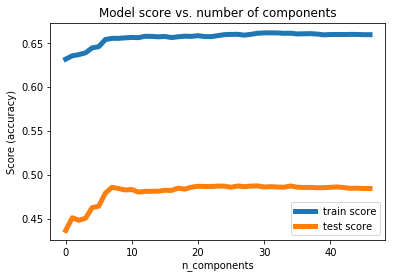

In [175]:
plt.plot(list(zip(train_scores, test_scores)), linewidth=5)
plt.title('Model score vs. number of components')
plt.xlabel('n_components')
plt.ylabel('Score (accuracy)')
plt.legend(['train score', 'test score'], loc='best')

I'll select the a *n_component*, based on the above.

In [176]:
pca_components = 8
scaled_pca_transformer = PCA(n_components=pca_components).fit(X_train_selected)
X_train_pca = scaled_pca_transformer.transform(X_train_selected)
X_test_pca = scaled_pca_transformer.transform(X_test_selected)

**Logistic Regression**

In [177]:
LogR_clf = LogisticRegression().fit(X_train_pca, y_train)
display_classification_report(LogR_clf, X_train_pca, y_train, X_test_pca, y_test)

Train report:
              precision    recall  f1-score   support

        <30       0.50      0.00      0.00      7935
        >30       0.50      0.21      0.29     24904
         NO       0.58      0.92      0.71     38052

avg / total       0.54      0.57      0.48     70891

Test report:
              precision    recall  f1-score   support

        <30       1.00      0.00      0.00      3422
        >30       0.49      0.20      0.28     10641
         NO       0.58      0.92      0.71     16319

avg / total       0.59      0.56      0.48     30382



Very poor results regarding the * '< 30' * category. I guess it's because of the imbalanced data. 
I'll address it soon.

**Decision Tree**

In [178]:
DT_clf = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10).fit(X_train_pca, y_train)
display_classification_report(DT_clf, X_train_pca, y_train, X_test_pca, y_test)

Train report:
              precision    recall  f1-score   support

        <30       0.68      0.56      0.61      7935
        >30       0.78      0.73      0.76     24904
         NO       0.81      0.87      0.84     38052

avg / total       0.78      0.79      0.78     70891

Test report:
              precision    recall  f1-score   support

        <30       0.15      0.13      0.14      3422
        >30       0.40      0.37      0.39     10641
         NO       0.59      0.62      0.60     16319

avg / total       0.47      0.48      0.47     30382



Overfitting :(

**SVM**

In [179]:
# SVM_clf = SVC().fit(X_train_pca, y_train)
# display_classification_report(SVM_clf, X_train_pca, y_train, X_test_pca, y_test)

**Random Forest**

In [180]:
RF_clf = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10).fit(X_train_pca, y_train)
display_classification_report(RF_clf, X_train_pca, y_train, X_test_pca, y_test)

Train report:
              precision    recall  f1-score   support

        <30       0.68      0.56      0.61      7935
        >30       0.78      0.73      0.76     24904
         NO       0.81      0.87      0.84     38052

avg / total       0.78      0.79      0.78     70891

Test report:
              precision    recall  f1-score   support

        <30       0.14      0.13      0.13      3422
        >30       0.39      0.37      0.38     10641
         NO       0.58      0.62      0.60     16319

avg / total       0.47      0.48      0.47     30382



Overfitting rules :)

### Trying to balance the imbalanced data by using Random over-sampling

In [253]:
# performing the over-sample manipulation on the 'train' part only
df = (pd.concat([X_train_selected, pd.DataFrame(y_train)], axis=1))
df.readmitted.value_counts()

NO     38052
>30    24904
<30     7935
Name: readmitted, dtype: int64

In [254]:
less_then_30_df = df.loc[df.readmitted == '<30']
less_then_30_df.shape

(7935, 49)

In [255]:
# sample twice the size of the df, to eventualy triple the number of '<30' rows
less_then_30_df_oversample = less_then_30_df.sample(2*less_then_30_df.shape[0], replace=True)

# concatenate the two parts
df_over = pd.concat([df,less_then_30_df_oversample], axis=0) 
df_over.readmitted.value_counts()

NO     38052
>30    24904
<30    23805
Name: readmitted, dtype: int64

In [260]:
X_train_over = df_over.drop(columns=['readmitted'])
y_train_over = df_over.readmitted

In [261]:
X_train_over.shape

(86761, 48)

In [262]:
scaled_pca_transformer = PCA(n_components=pca_components).fit(X_train_over)
X_train_pca = scaled_pca_transformer.transform(X_train_over)

# the test part is not affected by the over-sampling manipulation
X_test_pca = scaled_pca_transformer.transform(X_test_selected)

**Try it with LogisticRegression**

In [264]:
LogR_clf = LogisticRegression().fit(X_train_pca, y_train_over)
display_classification_report(LogR_clf, X_train_pca, y_train_over, X_test_pca, y_test)

Train report:
              precision    recall  f1-score   support

        <30       0.45      0.26      0.33     23805
        >30       0.41      0.04      0.08     24904
         NO       0.49      0.90      0.64     38052

avg / total       0.45      0.48      0.39     86761

Test report:
              precision    recall  f1-score   support

        <30       0.22      0.27      0.24      3422
        >30       0.51      0.04      0.07     10641
         NO       0.58      0.90      0.71     16319

avg / total       0.51      0.53      0.43     30382



There's an improvement in the '< 30' section, however the overall result is still poor.

### Improving results by using GridSearch and Ensembles

**LogisticRegression**

Trying to deal with the imbalanced data, I'm using the hyperparameter *class_weight='balanced'*

In [265]:
param_grid = {'clf_model__C': np.arange(0.01, 0.2, 0.1),
              'clf_model__class_weight': ['balanced']
             }
steps = [('clf_model', LogisticRegression())]
pipe = Pipeline(steps) 
grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(X_train_pca, y_train_over)
LR_GS_best = grid_search.best_estimator_
print(LR_GS_best,'\n')
display_classification_report(LR_GS_best, X_train_pca, y_train_over, X_test_pca, y_test)

Pipeline(memory=None,
     steps=[('clf_model', LogisticRegression(C=0.11, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]) 

Train report:
              precision    recall  f1-score   support

        <30       0.42      0.36      0.39     23805
        >30       0.37      0.11      0.17     24904
         NO       0.52      0.80      0.63     38052

avg / total       0.45      0.48      0.43     86761

Test report:
              precision    recall  f1-score   support

        <30       0.19      0.36      0.25      3422
        >30       0.45      0.10      0.16     10641
         NO       0.60      0.80      0.69     16319

avg / total       0.50      0.51      0.46     30382



**K-NN**

In [266]:
param_grid = {
              'clf_model__n_neighbors': range(10,20),
              'clf_model__p': [1]
             }
steps = [('clf_model', KNeighborsClassifier())]
pipe = Pipeline(steps) 
grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(X_train_pca, y_train_over)
KNN_GS_best = grid_search.best_estimator_
print(KNN_GS_best,'\n')
display_classification_report(KNN_GS_best, X_train_pca, y_train_over, X_test_pca, y_test)

Pipeline(memory=None,
     steps=[('clf_model', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=1,
           weights='uniform'))]) 

Train report:
              precision    recall  f1-score   support

        <30       0.55      0.70      0.62     23805
        >30       0.54      0.31      0.40     24904
         NO       0.63      0.69      0.66     38052

avg / total       0.58      0.59      0.57     86761

Test report:
              precision    recall  f1-score   support

        <30       0.14      0.33      0.20      3422
        >30       0.41      0.21      0.28     10641
         NO       0.59      0.60      0.60     16319

avg / total       0.47      0.44      0.44     30382



**RandomForest**

In [267]:
param_grid = {
              'clf_model__n_estimators': [10],
              'clf_model__criterion': ['gini','entropy'],
              'clf_model__class_weight': ['balanced'],
              'clf_model__max_features': ['auto', 5, 0.2],              
              'clf_model__min_samples_leaf': [20, 30, 40], 
              'clf_model__n_jobs': [-1],
              'clf_model__bootstrap': [True],
              'clf_model__oob_score': [False, True]
              }
steps = [('clf_model', RandomForestClassifier())]
pipe = Pipeline(steps) 
grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(X_train_pca, y_train_over)
RF_GS_best = grid_search.best_estimator_
print(RF_GS_best,'\n')
display_classification_report(RF_GS_best, X_train_pca, y_train_over, X_test_pca, y_test)

Pipeline(memory=None,
     steps=[('clf_model', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features=5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]) 

Train report:
              precision    recall  f1-score   support

        <30       0.75      0.88      0.81     23805
        >30       0.60      0.59      0.60     24904
         NO       0.74      0.67      0.71     38052

avg / total       0.70      0.71      0.70     86761

Test report:
              precision    recall  f1-score   support

        <30       0.17      0.27      0.21      3422
        >30       0.42      0.39      0.40     10641
         NO       0.64      0.59      0.61     16319

avg / tot

**SVM**

In [268]:
# param_grid = {
#               'clf_model__C': range(1, 10),
#               'clf_model__class_weight': ['balanced']
#              }
# steps = [('clf_model', SVC())]
# pipe = Pipeline(steps) 
# grid_search = GridSearchCV(pipe, param_grid, cv=10)
# grid_search.fit(X_train_pca, y_train_over)
# SVC_GS_best = grid_search.best_estimator_
# print(SVC_GS_best,'\n')
# display_classification_report(SVC_GS_best, X_train_pca, y_train_over, X_test_pca, y_test)

it took hours, so I killed it

**Ridge**

In [269]:
param_grid = {
              'clf_model__alpha': np.arange(1, 10, 0.5),
              'clf_model__max_iter': [50000],
              'clf_model__class_weight': ['balanced']
             }
steps = [('clf_model', RidgeClassifier())]
pipe = Pipeline(steps) 
grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(X_train_pca, y_train_over)
Ridge_GS_best = grid_search.best_estimator_
print(Ridge_GS_best,'\n')
display_classification_report(Ridge_GS_best, X_train_pca, y_train_over, X_test_pca, y_test)

Pipeline(memory=None,
     steps=[('clf_model', RidgeClassifier(alpha=1.0, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=50000, normalize=False,
        random_state=None, solver='auto', tol=0.001))]) 

Train report:
              precision    recall  f1-score   support

        <30       0.40      0.41      0.40     23805
        >30       0.33      0.22      0.26     24904
         NO       0.54      0.64      0.58     38052

avg / total       0.44      0.46      0.44     86761

Test report:
              precision    recall  f1-score   support

        <30       0.18      0.40      0.25      3422
        >30       0.39      0.21      0.28     10641
         NO       0.62      0.64      0.63     16319

avg / total       0.49      0.46      0.46     30382



**GradientBoosting**

In [270]:
param_grid = {
              'clf_model__n_estimators': [100],
              'clf_model__learning_rate': [0.05],
              'clf_model__max_features': ['auto', 5, 0.2],              
              'clf_model__min_samples_leaf': [20, 30, 40, 50]
             }
steps = [('clf_model', GradientBoostingClassifier())]
pipe = Pipeline(steps) 
grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(X_train_pca, y_train_over)
GB_GS_best = grid_search.best_estimator_
print(GB_GS_best,'\n')
display_classification_report(GB_GS_best, X_train_pca, y_train_over, X_test_pca, y_test)

Pipeline(memory=None,
     steps=[('clf_model', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]) 

Train report:
              precision    recall  f1-score   support

        <30       0.48      0.27      0.34     23805
        >30       0.43      0.12      0.19     24904
         NO       0.50      0.87      0.64     38052

avg / total       0.47      0.49      0.43     86761

Test report:
              precision    recall  f1-score   support

        <30       0.22      0.24      0.23      3422
        >30       0.50      0.11      0.18     10641
         NO    

**AdaBoost**

In [271]:
param_grid = {
              'clf_model__n_estimators': [50],
              'clf_model__learning_rate': [0.1, 0.5, 1]
             }
steps = [('clf_model', AdaBoostClassifier())]
pipe = Pipeline(steps) 
grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(X_train_pca, y_train_over)
AB_GS_best = grid_search.best_estimator_
print(AB_GS_best,'\n')
display_classification_report(AB_GS_best, X_train_pca, y_train_over, X_test_pca, y_test)

Pipeline(memory=None,
     steps=[('clf_model', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=50, random_state=None))]) 

Train report:
              precision    recall  f1-score   support

        <30       0.44      0.29      0.35     23805
        >30       0.39      0.12      0.18     24904
         NO       0.51      0.85      0.64     38052

avg / total       0.46      0.49      0.43     86761

Test report:
              precision    recall  f1-score   support

        <30       0.21      0.28      0.24      3422
        >30       0.48      0.11      0.18     10641
         NO       0.59      0.85      0.70     16319

avg / total       0.51      0.53      0.47     30382



**VotingClassifier**

In [272]:
classifiers = [('LR', LR_GS_best), ('GB', GB_GS_best), ('KNN', KNN_GS_best)]
param_grid = {
              'clf_model__n_jobs': [-1]
             }
steps = [('clf_model', VotingClassifier(classifiers))]
pipe = Pipeline(steps) 
grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(X_train_pca, y_train_over)
V_GS_best = grid_search.best_estimator_
print(V_GS_best,'\n')
display_classification_report(V_GS_best, X_train_pca, y_train_over, X_test_pca, y_test)

Pipeline(memory=None,
     steps=[('clf_model', VotingClassifier(estimators=[('LR', Pipeline(memory=None,
     steps=[('clf_model', LogisticRegression(C=0.11, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=... weights='uniform'))]))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=None))]) 

Train report:
              precision    recall  f1-score   support

        <30       0.47      0.39      0.42     23805
        >30       0.49      0.11      0.17     24904
         NO       0.52      0.85      0.65     38052

avg / total       0.50      0.51      0.45     86761

Test report:
              precision    recall  f1-score   support

        <30       0.20      0.33      0.24      3422
        >30       0.49      0.09      0.15     10641
         NO       0.60      0.84      0.70     16319

avg / total       0.52      0.52      0.45     30382



**BaggingClassifier**

In [273]:
param_grid = {
              'clf_model__n_estimators': [10],
              'clf_model__max_features': [5],              
              'clf_model__n_jobs': [-1],
              'clf_model__bootstrap': [True],
              'clf_model__oob_score': [False, True]
             }
steps = [('clf_model', BaggingClassifier())]
pipe = Pipeline(steps) 
grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(X_train_pca, y_train_over)
B_GS_best = grid_search.best_estimator_
print(B_GS_best,'\n')
display_classification_report(B_GS_best, X_train_pca, y_train_over, X_test_pca, y_test)

Pipeline(memory=None,
     steps=[('clf_model', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=5, max_samples=1.0,
         n_estimators=10, n_jobs=-1, oob_score=True, random_state=None,
         verbose=0, warm_start=False))]) 

Train report:
              precision    recall  f1-score   support

        <30       1.00      1.00      1.00     23805
        >30       0.99      0.99      0.99     24904
         NO       0.99      0.99      0.99     38052

avg / total       0.99      0.99      0.99     86761

Test report:
              precision    recall  f1-score   support

        <30       0.18      0.13      0.15      3422
        >30       0.39      0.36      0.38     10641
         NO       0.59      0.66      0.62     16319

avg / total       0.47      0.49      0.48     30382



Poor results... Well, I tried :)